## Implementing a Multilayer perceptron

In [98]:
from math import exp, log


class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other ** -1

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other
      
    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other
    # Todo here for miccrograd exercises

    def log(self):
        x = self.data
        out = Value(log(x), (self,), 'log')

        def _backward():
            self.grad += (x ** -1) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(exp(x), (self,), 'exp')

        def _backward():
            # self.grad += self.data * out.data
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')
    
      def _backward():
        self.grad += (1 - t**2) * out.grad
      out._backward = _backward

      return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [99]:
import random
import math

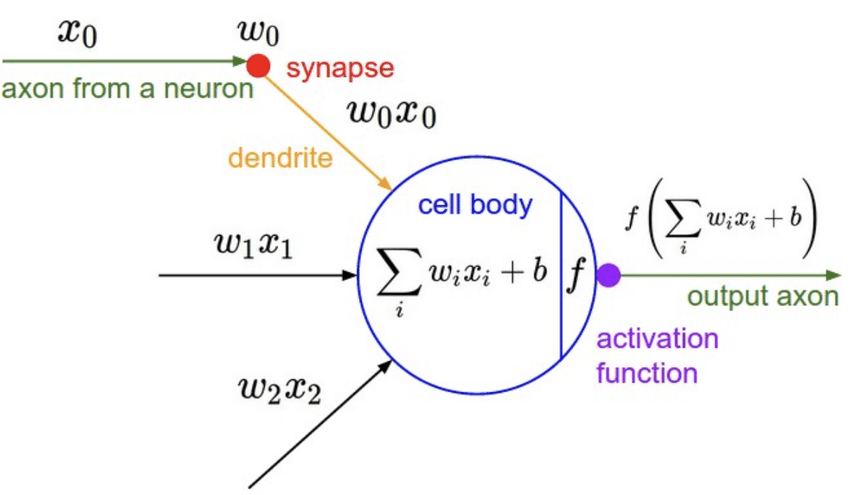




In [121]:
class Neuron :
  def __init__(self,no_inputs) :
    self.weight = [Value(random.uniform(-1,1)) for _ in range(no_inputs)]
    self.bias = Value(random.uniform(-1,1))

  def __call__(self, input_values):
    #weight * input_values(X in the picture) + bias
    act = sum((wi*xi for wi,xi in zip(self.weight,input_values))) + self.bias
    out=act.tanh()
    return out
  
  def parameters(self):
    return self.weight + [self.bias]
      

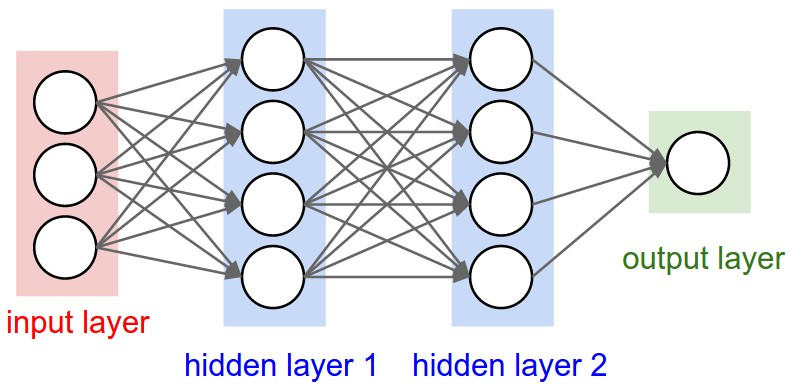

In [114]:
class Layer:
  #no_outputs is the same as no of neurons you want in the layer
  def __init__(self, no_inputs,no_outputs):
    self.neurons=[Neuron(no_inputs) for _ in range(no_outputs)]
  
  def __call__(self, input_values):
    outs=[n(input_values) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  def parameters(self):
    params=[]
    for neuron in self.neurons:
      ps=neuron.parameters()
      params.extend(ps)
    return params


In [113]:
class MLP:
  #no_outputs is a list of the sizes of each layer in the mlp
  def __init__ (self, no_inputs, no_outputs):
    sz= [no_inputs] + no_outputs
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(no_outputs))]
  def __call__(self, input_values):
    for layer in self.layers:
        input_values=layer(input_values)
    out=input_values
    return out
  def parameters(self):
    params=[]
    for layer in self.layers:
      ps=layer.parameters()
      params.extend(ps)
    return params  

In [163]:
input_values=[2.0, 3.0, -1.0]
n= MLP(3, [4 ,4 ,1])
n(input_values)

Value(data=0.6492237363398013)

In [197]:
# 4 possible input values
xs = [
  [2.0, 3.0, -1.0], # output should be 1 or ys[0]
  [3.0, -1.0, 0.5], # output should be -1 or ys[1]
  [0.5, 1.0, 1.0],  # output should be -1 or ys[2]
  [1.0, 1.0, -1.0], # output should be 1 or ys[3]
]
#output
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred=[n(x) for x in xs]
ypred

[Value(data=0.30480311921757364),
 Value(data=0.11886946305675289),
 Value(data=0.5496622589899717),
 Value(data=0.6036189212089519)]

In [ ]:
#forward pass
ypred=[n(x) for x in xs]

In [191]:
#mean^2 loss : output-expectedoutput(truth)^2
loss=sum([(yout-ygtruth)**2 for ygtruth, yout in zip(ys , ypred)])
loss

Value(data=4.429017487997604)

In [166]:
#backward pass
loss.backward()

In [196]:
# ajusting parameters using the oposite of the derivate to make loss closer to 0
for p in n.parameters():
  p.data += - 0.01 *p.grad

In [198]:
loss=sum([(yout-ygtruth)**2 for ygtruth, yout in zip(ys , ypred)])
loss

Value(data=4.293738654971979)

In [199]:
# 4 possible input values
xs = [
  [2.0, 3.0, -1.0], # output should be 1 or ys[0]
  [3.0, -1.0, 0.5], # output should be -1 or ys[1]
  [0.5, 1.0, 1.0],  # output should be -1 or ys[2]
  [1.0, 1.0, -1.0], # output should be 1 or ys[3]
]
#output
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred=[n(x) for x in xs]
ypred

[Value(data=0.30480311921757364),
 Value(data=0.11886946305675289),
 Value(data=0.5496622589899717),
 Value(data=0.6036189212089519)]

In [201]:
for _ in range(50):
  #forward pass
   ypred=[n(x) for x in xs]
   loss=sum([(yout-ygtruth)**2 for ygtruth, yout in zip(ys , ypred)])
  #backward pass
   loss.backward()
  #gradient decent
   for p in n.parameters():
      p.data += - 0.01 *p.grad
   print (_, loss.data)
ypred

0 9.928672758086228e-09
1 7.4414539992106036e-09
2 5.597691914038163e-09
3 4.2242887686214235e-09
4 3.196794727917376e-09
5 2.4251087920660775e-09
6 1.8435635640753042e-09
7 1.4039992243293994e-09
8 1.0708898844872202e-09
9 8.178889073724787e-10
10 6.253621691067679e-10
11 4.786140763480259e-10
12 3.6660286374297876e-10
13 2.8100397721388805e-10
14 2.1552289443331952e-10
15 1.6538797014384939e-10
16 1.26974112222683e-10
17 9.75221676245986e-11
18 7.492876064470838e-11
19 5.758828906102554e-11
20 4.4273735371170834e-11
21 3.404649814399187e-11
22 2.618800931228248e-11
23 2.0147765031413656e-11
24 1.5503760595756606e-11
25 1.1932323915971502e-11
26 9.18508614556593e-12
27 7.0713822741298175e-12
28 5.444789355076074e-12
29 4.192821760577938e-12
30 3.2290379197143524e-12
31 2.486990738591683e-12
32 1.915588765935373e-12
33 1.4755375057891247e-12
34 1.1366082677642034e-12
35 8.755413352662135e-13
36 6.744355778216289e-13
37 5.195112538596694e-13
38 4.001592351584833e-13
39 3.082101268062984

[Value(data=1.0),
 Value(data=-0.9999998851574333),
 Value(data=-0.999999903509165),
 Value(data=1.0)]